[En français](../use-case_skewt-interactive_fr/)  

![ECCC logo](https://eccc-msc.github.io/open-data/img_eccc-logo.png)  

[TOC](https://eccc-msc.github.io/open-data/readme_en/) > [Usage overview](https://eccc-msc.github.io/open-data/usage/readme_en/) > WMS request in Python

# Use case: sounding graphs based on open-data

## Introduction

Weather, climate and water data from [MSC GeoMet](https://eccc-msc.github.io/open-data/msc-geomet/readme_en/) geospatial web services can be easily used to predict demand associated with certain products or services. This usage example show how to extract and process raw meteorological data with [Python](https://www.python.org/) programming language to create a tool to calculate anticipated profits from sales depending on meteorological conditions. This use case teaches you how to:
* Access and query meteorological data from MSC GeoMet geospatial web services;
* Query layers to get data for specific locations;
* Create temporal queries;
* Show results in different formats including plots and data tables.

The [interactive version of this Jupyter Notebook is available](https://mybinder.org/v2/gh/ECCC-MSC/open-data/master?filepath=docs%2Fusage%2Fuse-case_arthur%2Fuse-case_arthur_en.ipynb).

[![badge](https://img.shields.io/badge/Interactive%20version-binder-F5A252.svg?logo=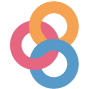)](https://mybinder.org/v2/gh/ECCC-MSC/open-data/master?filepath=docs%2Fusage%2Fuse-case_arthur%2Fuse-case_arthur_en.ipynb)

## Creation of a tool to extract and plot sounding data

Consider the following situation: Gerald exists...

To achieve this, the first step is to import the necessary Python modules and to select the desired request parameters.

In [1]:
# Remove the magic command to use out of Jupyter Notebook
%matplotlib widget

# Importation of Python modules
import datetime
import logging
import math
import re
import requests

# The following modules must first be installed to use 
# this code out of Jupyter Notebook
from adjustText import adjust_text
from matplotlib.font_manager import FontProperties
import matplotlib.patheffects as mpatheffects
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# metpy throws a Cartopy warning for no reason if you don't put that even though Cartopy isn't used...
metpy_plot_logger = logging.getLogger('metpy.plots')
metpy_plot_logger.setLevel(logging.ERROR)
import metpy.calc as mpcalc
import metpy.interpolate as mpinterpolate
from metpy.plots import Hodograph, SkewT
from metpy.units import units

# So we can have the degree symbol in the graph's title
DEG_SYMBOL = u"\N{DEGREE SIGN}"

# Time format used is UTC±00:00
ISO_FORMAT = '%Y-%m-%dT%H:%M:%SZ'

In [2]:
# Parameters choice

# Model (RDPS, GDPS or HRDPS):
model = 'RDPS'

# Data kept for current and previous day, so times
# are calculated below so they always work

# Model Run:
mr_date = datetime.date.today() - datetime.timedelta(days=1)
model_run = f'{mr_date.strftime("%Y-%m-%d")}T12:00:00Z'
# ex.: model_run = '2022-01-01T12:00:00Z'

# Forecast Hour:
forecast_hour = f'003: {mr_date.strftime("%Y-%m-%d")}T15:00:00Z'
# ex.: forecast_hour = '003: 2022-01-01T15:00:00Z'

# latitude and longitude,
# (Careful not to select coordinates that are oustide of the chosen model):
lat = 56.1303
lon = -106.3468

Now that the parameters have been chosen, a ``POST request`` needs to be sent to the ``extract-sounding-data OGC API - Process`` with those parameters so that the data can be retrieved in ``JSON`` format.

In [3]:
# URL to retrieve sounding data information
url = 'http://geomet-dev-03.cmc.ec.gc.ca:5099/processes/extract-sounding-data/execution'

# Format in which the data will be received
headers = {
    "Accept": "application/json",
    "Content-Type": "application/json",
}

# Parameters to pass for the request
body = {
    "inputs": {
        "forecast_hour": forecast_hour[0:3],
        "lat": lat,
        "lon": lon,
        "model": model,
        "model_run": model_run,
        "novalues_above_100mbar": True,
    }
}

# Make request and put the response in JSON format
# Response contains:
#    - Pressure (hPa/mbar)
#    - Temperature (°C)
#    - Dewpoint Temperature (°C)
#    - Dewpoint Depression (°C)
#    - Wind Speed (Knots)
#    - Wind Direction (°)
#    - CAPE, CIN (J/kg)
#    - LCL, LFC, EL (m AGL)
#    - LI (no unit)
resp = requests.post(url, json=body, headers=headers).json()

We will now extract the values from the received ``JSON`` response and we will place them inside lists so that they can be easily accessed and used later.

In [4]:
# Store the values for Skew-T and Hodograph plotting in lists and assign proper units

p = []  # List to store pressure levels
t = []  # List to store temperatures
td = []  # List to store dew point temperatures
ws = []  # List to store wind speeds
wd = []  # List to store wind directions
for key, val in resp['properties'].items():
    # Look for for souding data at every pressure level
    # If there ar less than 6 parameters, it means a value is missing so skip it
    if re.search(r'(\d+)mbar', key) and len(val) == 6:
        p.append(val['pressure'])
        t.append(val['air_temperature'])
        td.append(val['dew_point_temperature'])
        ws.append(val['wind_speed'])
        wd.append(val['wind_direction'])
p *= units.hPa
t *= units.degC
td *= units.degC
ws *= units.knots
wd *= units.degrees
u, v = mpcalc.wind_components(ws, wd)

Do the same now for the convection indices, but instead of just making lists, create a list of lists and arrange the data such that it can be placed inside a table.

In [5]:
# Store Convection Indices in a list of lists to make a table afterwards

# Convection indices currently unavailable for HRDPS, so if you
# select that model all you'll see is 'N/A' in the table

# Store convection indices' values inside lists
cape = list(resp['properties']['CAPE'].values())
cin = list(resp['properties']['CIN'].values())
lcl = list(resp['properties']['LCL'].values())
li = list(resp['properties']['LI'].values())
lfc = list(resp['properties']['LFC'].values())
el = list(resp['properties']['EL'].values())
### If value is wrong put N/A, comment out to get those values (if any)
for i, value in enumerate(cape):
    if type(value) in (int, float):
        if value < 0:
            cape[i] = 'N/A'
for i, value in enumerate(cin):
    if type(value) in (int, float):
        if value > 0:
            cin[i] = 'N/A'
for i, value in enumerate(lcl):
    if type(value) in (int, float):
        if value < 0:
            lcl[i] = 'N/A'
for i, value in enumerate(lfc):
    if type(value) in (int, float):
        if value < 0:
            lfc[i] = 'N/A'
for i, value in enumerate(el):
    if type(value) in (int, float):
        if value < 0:
            el[i] = 'N/A'
###

# Arrange them so they look great inside a table
conv_indices = []
for i in range(3):
    conv_indices.append([])
    for indices in [cape, cin, lcl, li, lfc, el]:
        # If there's a value, round it
        if isinstance(indices[i], float):
            conv_indices[i].append(round(indices[i]))
        else:
            conv_indices[i].append(indices[i])

# Add a row for Convection Indices' units
conv_indices.append([])
conv_indices[-1].extend([resp['properties']['CAPE_unit'],
                         resp['properties']['CIN_unit'],
                         resp['properties']['LCL_unit'],
                         resp['properties']['LI_unit'],
                         resp['properties']['LFC_unit'],
                         resp['properties']['EL_unit']
                         ]
                        )

Now that all the data has been arranged, we can finally start plotting. First, we will make a ``Skew-T Log-P Diagram`` using the ``Metpy`` library.

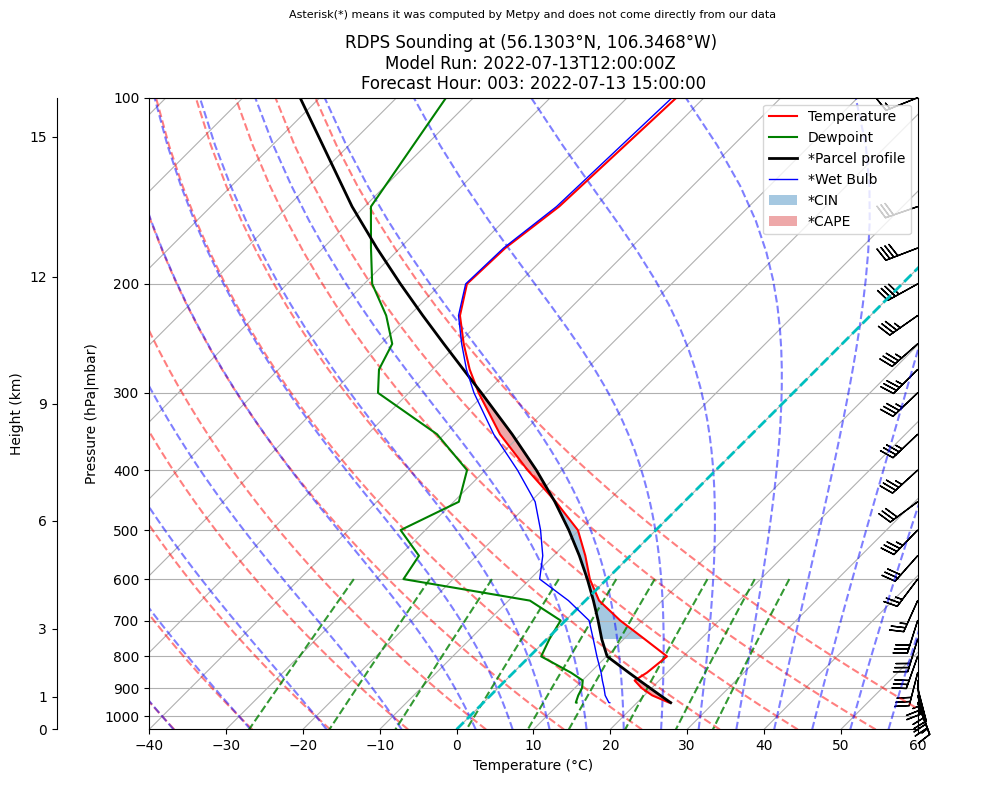

In [6]:
# Plotting a Skew-T Log-P diagram using the Metpy library

# Prevent matplotlib to show whatever it wants
plt.ioff()

fig = plt.figure(figsize=(10, 8), tight_layout=True)
skew = SkewT(fig, rotation=45)
skew.plot(p[:len(t)], t, 'r', label='Temperature')
skew.plot(p[:len(td)], td, 'g', label='Dewpoint')
skew.plot_barbs(p[:len(ws)], u, v)
skew.ax.set_ylim(1050, 100)
skew.ax.set_xlim(-40, 60)
skew.ax.xaxis.set_label_text('Temperature (°C)')
skew.ax.yaxis.set_label_text('Pressure (hPa|mbar)')

# Add a secondary axis that automatically converts between pressure and height
# assuming a standard atmosphere. The value of -0.12 puts the secondary axis
# 0.12 normalized (0 to 1) coordinates left of the original axis.
secax = skew.ax.secondary_yaxis(
    -0.12,
    functions=(
        lambda p: mpcalc.pressure_to_height_std(units.Quantity(p, 'hPa')).m_as('km'),
        lambda h: mpcalc.height_to_pressure_std(units.Quantity(h, 'km')).m
    )
)
# Show 0, 1, 3, 6, 9, 12, 15 km marks
secax.yaxis.set_major_locator(plt.FixedLocator([0, 1, 3, 6, 9, 12, 15]))
secax.yaxis.set_minor_locator(plt.NullLocator())
secax.yaxis.set_major_formatter(plt.ScalarFormatter())
secax.set_ylabel('Height (km)')

# Calculate full parcel profile and add to plot as black line
prof = mpcalc.parcel_profile(p, t[0], td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2, label='*Parcel profile')

# Shade areas of CAPE and CIN
skew.shade_cin(p, t, prof, td, label='*CIN')
skew.shade_cape(p, t, prof, label='*CAPE')

# Slanted line at 0 isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
wet_bulb = mpcalc.wet_bulb_temperature(p, t, td)
skew.plot(p, wet_bulb, 'b', linewidth=1, label='*Wet Bulb')
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Add title with all the data that was used for the plot
skew.ax.title.set_text(f'{model} Sounding at (' +
                       f'{str(lat) + DEG_SYMBOL + "N" if lat >= 0 else str(lat*-1) + DEG_SYMBOL + "S"}, ' +
                       f'{str(lon) + DEG_SYMBOL + "E" if lon >= 0 else str(lon*-1) + DEG_SYMBOL + "W"}) ' + '\n' +
                       f'Model Run: {model_run} ' + '\n' +
                       f'Forecast Hour: {forecast_hour[0:5]}{datetime.datetime.strptime(forecast_hour[5:], "%Y-%m-%dT%H:%M:%SZ")}'
                       )
fig.suptitle('Asterisk(*) means it was computed by Metpy and does not come directly from our data', fontsize=8, x=0.53)
skew.ax.legend()

# Use plt.show() or plt.savefig('name.png') outside of Jupyter Notebook
display(fig)

Since we have the wind data, we can also plot a Hodograph, again using the ``Metpy`` library. The code underneath is quite large, but most of it is for looks. If you simply wish to create a Hodograph with code that's as simple as possible, please refer to ``Metpy Hodograph inset`` example or ``Metpy Skew-T with Complex Layout`` example, which will give you not only a simpler Hodograph, but also a simpler example for the ``Skew-T Log-P Diagram`` as well. The code below zooms on the Hodograph plot so that you don't have a huge plot where the winds are all packed in a tiny space. If you ever feel like th Hodograph is too small (which can happen if winds are ALL at 0°, 90°, etc. or close to it as, since we are zooming on the the lines, if the winds are purely vertical or horizontal the plot will be incredibly tin), you can simply comment out (put a ``#`` synbol in front of the line) the line ``h.ax.autoscale()`` and the plot will been shown in its entirety.

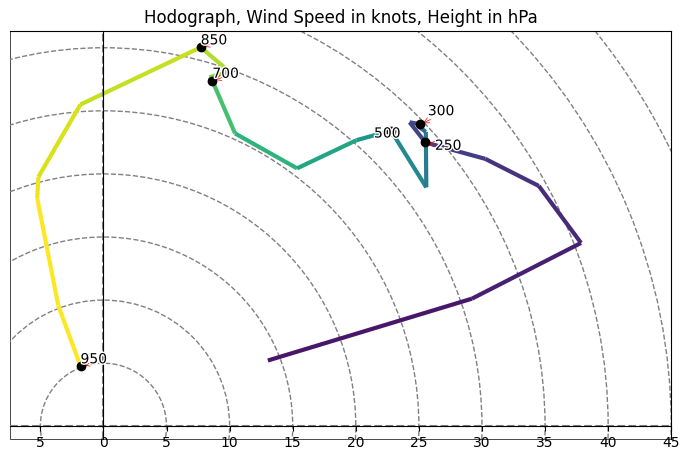

In [7]:
# Plotting a Hodograph using the Metpy library

fig = plt.figure(figsize=(7, 7), tight_layout=True)
ax = fig.add_subplot(1, 1, 1)

# Pressure level values to display on the Hodograph if present
boundaries_default = [950, 850, 700, 500, 300, 250]
# Always show first pressure level
boundaries_p = [p[0].magnitude]

# Also show all the ones from the list above, but only if they're over
# the first pressure level and are at least 50mbar over first pressure level
# i.e. if first pressure level is at 855mbar, don't show 950 nor 850
boundaries_p.extend([bd for bd in boundaries_default if ((boundaries_p[0]-bd)>=50 and bd>=p[-1].magnitude)])
boundaries_p *= units.hPa
u_pts, v_pts = mpinterpolate.interpolate_1d(boundaries_p, p, u, v)
boundaries_p[0] = round(boundaries_p[0])

# Add the points on the Hodograph for the chosen pressure levels
ax.scatter(u_pts, v_pts, c="black", zorder=10)
texts = []
for up, vp, z in zip(u_pts, v_pts, boundaries_p):
    z_str = int(z.magnitude)
    texts.append(ax.text(up, vp, z_str, ha='center', fontsize=10,
                    path_effects=[mpatheffects.withStroke(foreground='white', linewidth=2)],
                    zorder=12)
                )

# Scale hodograph according to strongest wind value
max_range = math.ceil(max(ws).magnitude) + 1
h = Hodograph(ax, component_range=max_range)

if max_range < 50:
    inc = math.ceil(max_range / 10)
else:
    inc = 5 * math.ceil(max_range / 100)

# Put axes in the middle of the graph
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.patch.set_edgecolor('black')
ax.patch.set_linewidth('0.5')

# Add color that changes with pressure levels
h.plot_colormapped(u, v, p)

# Rescale hodograph to zoom where the values are
# Comment h.ax.autoscale() if you want the entire Hodograph instead
h.ax.autoscale()
bottom, top = h.ax.get_ylim()
left, right = h.ax.get_xlim()

# Add the grid lines for the wind speeds
h.add_grid(increment=inc)

# Make sure axes stay inside the plot if the winds are all super far in one direction
if left > 0:
    left = -1
if bottom > 0:
    bottom = -1
if right < 0:
    right = 1
if top < 0:
    top = 1

# Resize the hodograph to zoom in on the plot, but only show values on the longest axis
# and add a little buffer to make sure the entire plot always fits inside.
norm_bottom = abs(bottom)
norm_left = abs(left)
whole, remainder = divmod(max_range, inc)
highest = max(norm_bottom, top, norm_left, right)
if highest in (norm_bottom, top):
    if highest == norm_bottom:
        norm_bottom = (whole + math.ceil(remainder/inc)) * inc
    else:
        top = (whole + math.ceil(remainder/inc)) * inc
    ax.set_ylim(bottom=-norm_bottom, top=top)
    ax.set_xlim(left=-norm_left, right=right)
    
    ax.yaxis.set_major_locator(mticker.MultipleLocator(inc))
    ticks_loc_y = ax.get_yticks().tolist()
    ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc_y))
    ax.set_yticklabels([f'{abs(int(y))}' for y in ticks_loc_y])
    ax.set_xticks([])
else:
    if highest == norm_left:
        norm_left = (whole + math.ceil(remainder/inc)) * inc
    else:
        right = (whole + math.ceil(remainder/inc)) * inc
    ax.set_ylim(bottom=-norm_bottom, top=top)
    ax.set_xlim(left=-norm_left, right=right)
    
    ax.xaxis.set_major_locator(mticker.MultipleLocator(inc))
    ticks_loc_x = ax.get_xticks().tolist()
    ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc_x))
    ax.set_xticklabels([f'{abs(int(x))}' for x in ticks_loc_x])
    ax.set_yticks([])

# Remove axes labels since the axes are in the middle of the plot
ax.set_xlabel('')
ax.set_ylabel('')

h.ax.title.set_text('Hodograph, Wind Speed in knots, Height in hPa')

# Make sure hodograph points' text don't overlap
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle='->', color='r', lw=0.5), expand_text=(1.8, 1.8), expand_points=(0, 0))

# Use plt.show() or plt.savefig('name.png') outside of Jupyter Notebook
display(fig)

Finally, we've also gotten the convection indices from the ``Process`` and we've already arranged the data so it could be displayed as a table, so let's do just that!

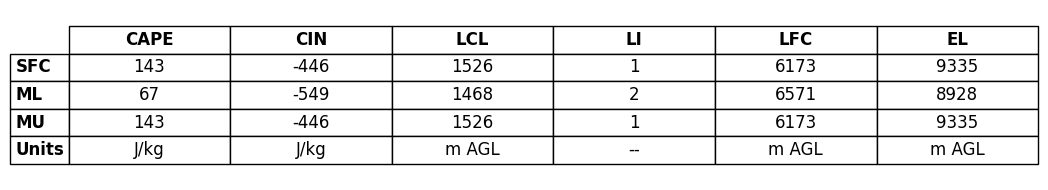

In [8]:
# Plotting Convection Indices table

fig = plt.figure(figsize=(12, 2), tight_layout=True)
table_ax = fig.add_subplot(1, 1, 1)
table_ax.axis('tight')
table_ax.axis('off')

# Table's columns and rows names
col_names = ['CAPE', 'CIN', 'LCL', 'LI', 'LFC', 'EL']
row_names = ['SFC', 'ML', 'MU', 'Units']
tab = table_ax.table(cellText=conv_indices, colLabels=col_names, rowLabels=row_names, loc='center', cellLoc='center')

# Change table font size and scale to look better
tab.auto_set_font_size(False)
tab.set_fontsize(12)
tab.scale(1.5, 1.5)

# Populate the table
for (row, col), cell in tab.get_celld().items():
    # Put rows and column titles bold
    if (row == 0) or (col == -1):
        cell.set_text_props(fontproperties=FontProperties(size=12, weight='bold'))

# Use plt.show() or plt.savefig('name.png') outside of Jupyter Notebook
display(fig)

## Conclusion

Using this tool, Gerald will have an insight of...